# Quant Project — Systematic Strategy Research

This notebook implements a complete, reproducible pipeline for the design, testing, and analysis of systematic trading strategies.  
It is structured to follow a typical quantitative research workflow from data acquisition to performance reporting.

## Scope of the Project

The objective is to construct, evaluate, and document a rules-based strategy applied to a universe of selected equities (e.g., AAPL, MSFT, AMZN, GOOG), and compare its performance to a benchmark index.

## Research Workflow

1. **Data Acquisition**
   - Download daily OHLCV price data for the chosen asset universe.
   - Align all time series on a common date index and integrate a benchmark for comparison.

2. **Feature Engineering**
   - Compute relevant technical indicators such as SMA, EMA, momentum, volatility, and RSI.
   - Produce a clean feature matrix that can be used for signal generation.

3. **Signal Generation**
   - Define deterministic trading rules (e.g., SMA crossovers confirmed by momentum).
   - Generate long, short, or flat signals for each asset on each trading day.

4. **Portfolio Construction**
   - Convert signals into portfolio weights and normalize exposure.
   - Apply a periodic rebalancing schedule (weekly or monthly).
   - Include transaction costs to approximate realistic execution.

5. **Backtesting**
   - Compute portfolio gross and net returns.
   - Generate an equity curve and compare with the benchmark.

6. **Performance Evaluation**
   - Calculate key performance statistics: CAGR, volatility, Sharpe ratio, Sortino ratio, and maximum drawdown.
   - Visualize drawdowns to assess risk characteristics.

7. **Parameter Optimization**
   - Perform a grid search on a training window to find robust parameter sets.
   - Evaluate selected parameters on a separate test window to mitigate overfitting.

8. **Robustness and Sensitivity Analysis**
   - Assess the impact of different transaction costs.
   - Implement volatility targeting to stabilize portfolio risk.
   - Optionally test hedging against benchmark beta and leverage scenarios.

9. **Reporting**
   - Save key metrics, parameter results, and plots to `reports/` and `figures/`.
   - Export best parameters for reproducibility.
   - Provide a command-line interface (`run_experiment.py`) to easily re-run the strategy with new tickers or timeframes.

## Deliverables

- A fully reproducible research notebook.
- Performance metrics and plots saved to disk.
- Parameter selection results based on out-of-sample validation.
- A lightweight code package (`src/`) containing reusable modules.
- A minimal command-line tool to execute experiments without re-running the entire notebook manually.

---

This project serves as a compact but rigorous template for systematic strategy research and can be extended with alternative signals, portfolio construction methods, or risk management techniques.


# Phase 1 — Data & Features (WHY)

**Goal:** Prepare clean, aligned market data and build features that can generate signals **without look-ahead bias**.

**Why each step:**
- **Download OHLCV:** We need high-quality inputs (prices, volume) to compute features.
- **Align calendars:** Different tickers miss different days; intersecting dates ensures apples-to-apples alignment.
- **Shift(1) on features:** Forces features to use **yesterday’s info** so signals at day *t* don’t “peek” into the future.
- **Technical features:**
  - **SMA10/SMA30:** Trend filters (short vs long trend).
  - **EMA20:** Faster trend smoother.
  - **Momentum(20d):** Trend continuation.
  - **Volatility(20d):** Risk/position sizing context.
  - **RSI14:** Overbought/oversold context (shifted to avoid look-ahead).


In [1]:
# -----------------------------
# CELL 1: DATA + FEATURES
# -----------------------------

# 0) Imports & plotting config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (8, 3)

# 1) Parameters (tickers, benchmark, date range)
SYMS  = ["AAPL", "MSFT", "AMZN", "GOOG"]  # universe
BENCH = "SPY"                              # benchmark for later comparison
START, END = "2015-01-01", "2024-12-31"

# 2) Helper: download OHLCV for a single symbol
def load_prices(symbol: str, start=START, end=END) -> pd.DataFrame:
    """
    Downloads OHLCV from Yahoo Finance and returns a tidy DataFrame with Date index.
    """
    df = yf.download(symbol, start=start, end=end, progress=False, auto_adjust=False)
    # Standardize column names and keep the essentials
    df = df.rename(columns=str.title)[["Open","High","Low","Close","Adj Close","Volume"]]
    return df.dropna().sort_index()

# 3) Download all assets + benchmark
prices = {sym: load_prices(sym) for sym in SYMS}
bench  = load_prices(BENCH)

# 4) Align ALL series on the same calendar (intersection of dates)
common_idx = bench.index
for s in SYMS:
    common_idx = common_idx.intersection(prices[s].index)

for s in SYMS:
    prices[s] = prices[s].reindex(common_idx).dropna()
bench = bench.reindex(common_idx).dropna()

# 5) Feature engineering helpers
def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """
    Classic RSI implementation (Wilder’s smoothing).
    """
    delta = series.diff()
    up    = delta.clip(lower=0).ewm(alpha=1/period, adjust=False).mean()
    down  = (-delta.clip(upper=0)).ewm(alpha=1/period, adjust=False).mean()
    rs = up / down
    return 100 - (100 / (1 + rs))

def build_features(close: pd.Series) -> pd.DataFrame:
    """
    Builds a small set of technical features.
    IMPORTANT: we use shift(1) so features ONLY use information available at t-1
    (avoids look-ahead bias).
    """
    f = pd.DataFrame(index=close.index)
    f["close"]  = close
    f["ret1"]   = close.pct_change()                # raw daily return
    f["logret"] = np.log(close).diff()              # log-return
    f["sma10"]  = close.shift(1).rolling(10).mean() # slow -> uses yesterday's info
    f["sma30"]  = close.shift(1).rolling(30).mean()
    f["ema20"]  = close.shift(1).ewm(span=20, adjust=False).mean()
    f["mom20"]  = close.shift(1) / close.shift(21) - 1  # 20-day momentum (shifted)
    f["vol20"]  = f["ret1"].rolling(20).std()           # rolling volatility (uses returns)
    f["rsi14"]  = rsi(close).shift(1)                   # shifted RSI to avoid look-ahead
    return f

# 6) Build features for the whole universe
feats = {s: build_features(prices[s]["Close"]) for s in SYMS}

# 7) Quick sanity checks (optional prints)
print("Universe:", SYMS, "| Benchmark:", BENCH)
print("Date range:", str(common_idx.min().date()), "→", str(common_idx.max().date()))
print("Sample features (AAPL):")
display(feats["AAPL"].tail(3))


Universe: ['AAPL', 'MSFT', 'AMZN', 'GOOG'] | Benchmark: SPY
Date range: 2015-01-02 → 2024-12-30
Sample features (AAPL):


,close,ret1,logret,sma10,sma30,ema20,mom20,vol20,rsi14
Date,,,,,,,,,
2024-12-26,259.019989,0.003176,0.003171,251.290002,240.166666,246.678681,0.108773,0.008782,75.682893
2024-12-27,255.589996,-0.013242,-0.013331,252.543001,241.326333,247.854044,0.101931,0.009615,76.386796
2024-12-30,252.199997,-0.013263,-0.013352,253.306000,242.341999,248.590801,0.087941,0.010262,67.575020


# Phase 2 — Signals, Weights, Backtest, Metrics (WHY)

**Goal:** Turn features into tradeable decisions, simulate execution with realistic frictions, and measure performance.

**Why each step:**
- **Signals (trend + momentum):** Simple, robust logic to capture continuation.
- **Normalize weights by gross exposure:** Keep **sum(|w|)=1** so risk is comparable day to day.
- **Weekly rebalance + transaction costs:** Lower turnover (realistic) and penalize trading.
- **Lag weights by 1 day:** Apply returns to yesterday’s positions → **no look-ahead**.
- **Metrics:** Standard *risk/return* view (CAGR, Vol, Sharpe, Sortino, MaxDD).
- **Plots:** Equity vs benchmark + drawdown → quick quality & pain profile check.


Metrics (gross):


CAGR      -0.0459
Vol        0.2304
Sharpe    -0.0886
Sortino   -0.1153
MaxDD     -0.5408
dtype: float64


Metrics (net):


CAGR      -0.0588
Vol        0.2305
Sharpe    -0.1474
Sortino   -0.1919
MaxDD     -0.5633
dtype: float64

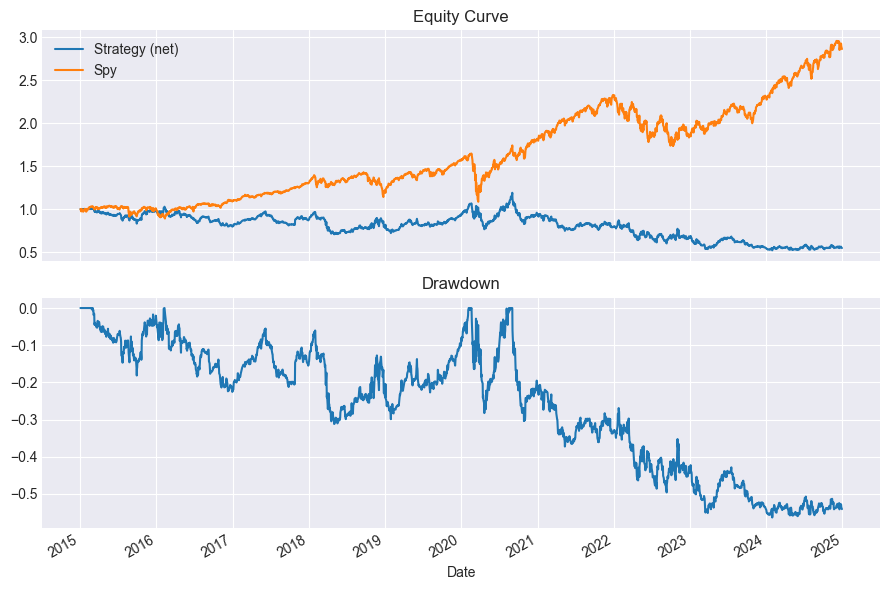

In [2]:
# -----------------------------
# CELL 2: SIGNALS + BACKTEST
# -----------------------------

TRADING_DAYS = 252

# 1) Turn features into trading signals (simple trend + momentum)
def signals_from_features(f: pd.DataFrame) -> pd.Series:
    """
    Long (+1)  when SMA10 > SMA30 and momentum > 0
    Short (-1) when SMA10 < SMA30 and momentum < 0
    Flat (0)   otherwise
    """
    sig = pd.Series(0.0, index=f.index)
    long  = (f["sma10"] > f["sma30"]) & (f["mom20"] > 0)
    short = (f["sma10"] < f["sma30"]) & (f["mom20"] < 0)
    sig[long]  =  1.0
    sig[short] = -1.0
    return sig

sigs = {s: signals_from_features(feats[s]) for s in SYMS}

# 2) Convert signals into daily portfolio weights
def stack_weights(signals: dict[str, pd.Series]) -> pd.DataFrame:
    """
    Normalize each day's signals so that sum(|weights|) = 1.
    This keeps gross exposure stable regardless of how many longs/shorts we have.
    """
    idx = next(iter(signals.values())).index
    W = pd.DataFrame(index=idx, columns=SYMS, dtype=float)
    for t in idx:
        row = pd.Series({s: signals[s].loc[t] for s in SYMS}, dtype=float)
        gross = row.abs().sum()
        W.loc[t] = (row / gross) if gross > 0 else 0.0
    return W.fillna(0.0)

W_base = stack_weights(sigs)

# 3) Build a price matrix (Close) aligned with weights dates
def align_close(prices_dict: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Returns a DataFrame of Close prices for the whole universe, same index/columns.
    """
    df = pd.concat({k: v["Close"] for k, v in prices_dict.items()}, axis=1)
    df.columns = list(prices_dict.keys())
    return df.sort_index()

CLOSE = align_close(prices)

# 4) Vectorized backtest with weekly rebalancing and transaction costs
def backtest_weights(CLOSE: pd.DataFrame, W: pd.DataFrame,
                     rebalance: str = "W-FRI", tcost: float = 0.0005) -> pd.DataFrame:
    """
    - Rebalance weights at chosen frequency (e.g., 'W-FRI')
    - Apply transaction costs proportional to turnover (sum of |Δw|)
    - Use lagged weights (shift by 1 day) to avoid look-ahead when applying returns
    Returns: DataFrame with gross, net returns and turnover.
    """
    R = CLOSE.pct_change().fillna(0.0)                            # asset daily returns
    W_rb = W.resample(rebalance).last().reindex(R.index).ffill()  # rebalance schedule
    turnover = W_rb.diff().abs().sum(axis=1).fillna(0.0)          # daily gross turnover
    cost = tcost * turnover                                       # transaction costs
    port_ret_gross = (W_rb.shift(1) * R).sum(axis=1).fillna(0.0)  # apply yesterday's weights
    port_ret_net   = port_ret_gross - cost
    return pd.DataFrame({"gross": port_ret_gross, "net": port_ret_net, "turnover": turnover})

bt = backtest_weights(CLOSE, W_base, rebalance="W-FRI", tcost=0.0005)

# 5) Standard performance metrics (annualized)
def metrics(returns: pd.Series, rf: float = 0.0) -> pd.Series:
    """
    Computes CAGR, Vol, Sharpe, Sortino, and Max Drawdown from a daily return series.
    """
    r = returns.dropna()
    cagr    = (1 + r).prod()**(TRADING_DAYS/len(r)) - 1
    vol     = r.std() * np.sqrt(TRADING_DAYS)
    downside= r[r < 0].std() * np.sqrt(TRADING_DAYS)
    sharpe  = (r.mean()*TRADING_DAYS - rf)/vol      if vol      > 0 else np.nan
    sortino = (r.mean()*TRADING_DAYS - rf)/downside if downside > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq/eq.cummax() - 1).min()
    return pd.Series({"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "Sortino": sortino, "MaxDD": maxdd})

print("Metrics (gross):")
display(metrics(bt["gross"]).round(4))
print("\nMetrics (net):")
display(metrics(bt["net"]).round(4))

# 6) Quick visuals: equity vs benchmark, and strategy drawdown
bench_ret = bench["Close"].pct_change().reindex(bt.index).fillna(0.0)
eq_port  = (1 + bt["net"]).cumprod()
eq_bench = (1 + bench_ret).cumprod()

fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# Equity curves
eq_port.plot(ax=ax[0], label="Strategy (net)")
eq_bench.plot(ax=ax[0], label=BENCH)
ax[0].set_title("Equity Curve"); ax[0].legend()

# Drawdown
dd = eq_port/eq_port.cummax() - 1
dd.plot(ax=ax[1])
ax[1].set_title("Drawdown")

plt.tight_layout(); plt.show()


# Phase 3 — μ & Σ, Monte Carlo, Max-Sharpe, Comparison (WHY)

**Goal:** Understand portfolio construction quality and compare your strategy to a **theoretically efficient** long-only allocation.

**Why each step:**
- **Estimate μ & Σ (from log-returns):** Inputs to modern portfolio theory.
- **Monte Carlo weights:** Visualize the **risk–return cloud** and where “good” portfolios live.
- **Max-Sharpe optimization:** Find the long-only portfolio with best risk-adjusted return under ∑w=1.
- **Compare to your strategy:** See if a constant optimized mix beats (or complements) your signal-driven portfolio.
- **Equity & Drawdowns comparison:** Judge practical differences in growth and pain.


Max-Sharpe weights:


AAPL    0.326
MSFT    0.300
AMZN    0.364
GOOG    0.010
dtype: float64

Opt Sharpe: 0.928  |  Return: 23.82%  |  Vol: 25.67%


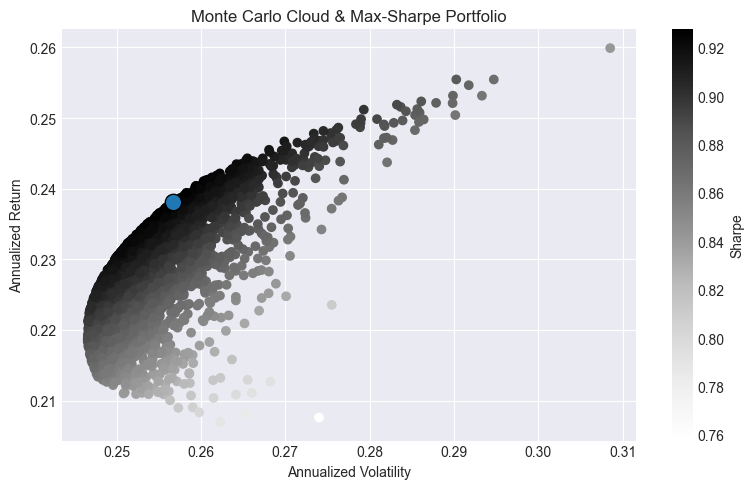


== Metrics: Strategy (net) vs Max-Sharpe (gross) ==


,Strategy (net),Max-Sharpe (gross)
CAGR,-0.0588,0.2830
Vol,0.2305,0.2568
Sharpe,-0.1474,1.0993
Sortino,-0.1919,1.4910
MaxDD,-0.5633,-0.3941


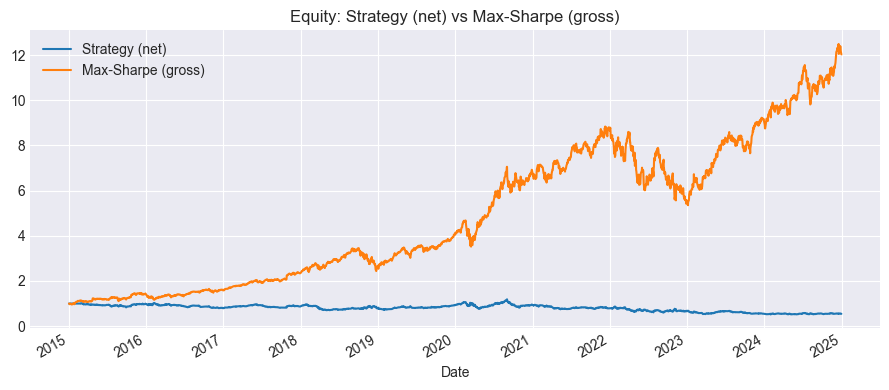

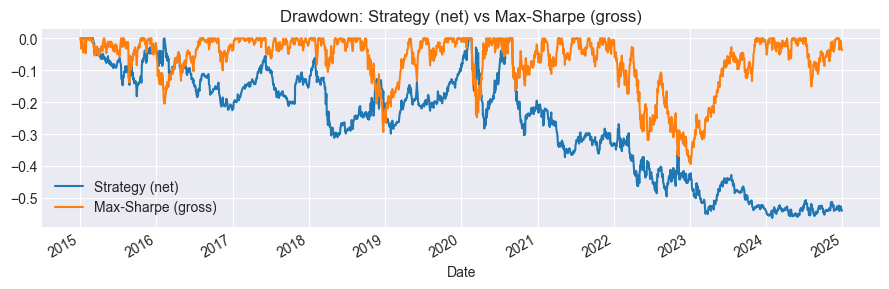

In [3]:
# -----------------------------
# CELL 3: μ & Σ → Monte Carlo → Max Sharpe → Comparison
# -----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252  # already defined earlier, re-stating for clarity

# 1) Estimate expected returns (μ) and covariance (Σ) from log-returns, annualized
logret = np.log(CLOSE).diff().dropna()
mu  = logret.mean() * TRADING_DAYS            # Series: exp. return per asset
cov = logret.cov()  * TRADING_DAYS            # DataFrame: covariance matrix

# 2) Utility: compute (annual) portfolio return & vol for any weight vector
def portfolio_return_vol(w, mu, cov):
    """
    r = w' μ
    v = sqrt(w' Σ w)
    Accepts mu/cov as pandas or numpy.
    """
    w  = np.asarray(w, dtype=float).reshape(-1)
    mu = np.asarray(mu, dtype=float).reshape(-1)
    C  = np.asarray(cov, dtype=float)
    r = float(w @ mu)
    v = float(np.sqrt(w @ C @ w))
    return r, v

# 3) Monte Carlo: sample many random weight vectors on the simplex to map risk–return space
rng = np.random.default_rng(7)

def rand_weights(n, rng=rng):
    x = rng.random(n)
    s = x.sum()
    return (x / s) if s > 0 else np.ones(n) / n

N = 3000
Wmc = np.array([rand_weights(len(mu)) for _ in range(N)])
rets_mc = Wmc @ mu.values
vols_mc = np.sqrt(np.einsum("ij,jk,ik->i", Wmc, cov.values, Wmc))
srs_mc  = np.where(vols_mc > 0, rets_mc / vols_mc, np.nan)

# 4) Max Sharpe optimization (SLSQP if SciPy is present; otherwise random sampling fallback)
try:
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

bounds = [(0.0, 1.0)] * len(mu)                       # long-only box constraints
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)

def neg_sharpe(w, mu, cov, rf=0.0):
    r, v = portfolio_return_vol(w, mu, cov)
    return -(r - rf) / v if v > 0 else 1e9

w0 = np.full(len(mu), 1.0 / len(mu))                   # start at equal weights

if SCIPY_OK:
    res = minimize(neg_sharpe, w0, args=(mu, cov, 0.0),
                   method="SLSQP", bounds=bounds, constraints=constraints,
                   options={'maxiter': 2000, 'ftol': 1e-12})
    if not res.success:
        print("SLSQP did not converge:", res.message)
    w_opt = res.x if res.success else w0
else:
    # Fallback: pick the best Sharpe from a large random sample
    best_sr, best_w = -np.inf, None
    for _ in range(50_000):
        w = rand_weights(len(mu))
        r, v = portfolio_return_vol(w, mu, cov)
        sr = (r / v) if v > 0 else -np.inf
        if sr > best_sr:
            best_sr, best_w = sr, w
    w_opt = best_w

# 5) Report optimal weight vector & its stats
r_opt, v_opt = portfolio_return_vol(w_opt, mu, cov)
sr_opt = r_opt / v_opt
print("Max-Sharpe weights:")
display(pd.Series(w_opt, index=CLOSE.columns).round(3))
print(f"Opt Sharpe: {sr_opt:.3f}  |  Return: {r_opt:.2%}  |  Vol: {v_opt:.2%}")

# 6) Plot Monte Carlo cloud + optimal portfolio point
fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(vols_mc, rets_mc, c=srs_mc)  # risk–return cloud
ax.scatter([v_opt], [r_opt], s=140, edgecolors="black", zorder=5)  # optimal point
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Return")
ax.set_title("Monte Carlo Cloud & Max-Sharpe Portfolio")
plt.colorbar(sc, label="Sharpe")
plt.tight_layout(); plt.show()

# 7) Build a constant-weight portfolio with w_opt and compare to your strategy
def backtest_constant_weights(CLOSE, w, tcost=0.0005):
    """
    Applies a fixed weight vector every day (uses lagged weights).
    Subtract simple daily transaction cost only when weights change (here they don't).
    """
    R = CLOSE.pct_change().fillna(0.0)
    w = pd.Series(w, index=CLOSE.columns)
    # constant weights → no turnover after day 1 (ignore day-1 cost for simplicity)
    port_ret = (R * w).sum(axis=1)
    return port_ret

bt_opt = backtest_constant_weights(CLOSE, w_opt)  # gross series (no turnover beyond day-1)

def metrics(returns: pd.Series, rf: float = 0.0):
    r = returns.dropna()
    cagr    = (1 + r).prod()**(TRADING_DAYS/len(r)) - 1
    vol     = r.std() * np.sqrt(TRADING_DAYS)
    downside= r[r < 0].std() * np.sqrt(TRADING_DAYS)
    sharpe  = (r.mean()*TRADING_DAYS - rf)/vol      if vol      > 0 else np.nan
    sortino = (r.mean()*TRADING_DAYS - rf)/downside if downside > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq/eq.cummax() - 1).min()
    return pd.Series({"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "Sortino": sortino, "MaxDD": maxdd})

print("\n== Metrics: Strategy (net) vs Max-Sharpe (gross) ==")
m_strat = metrics(bt["net"]).round(4)   # from your Cell 2 backtest
m_opt   = metrics(bt_opt).round(4)
display(pd.concat([m_strat.rename("Strategy (net)"),
                   m_opt.rename("Max-Sharpe (gross)")], axis=1))

# 8) Equity curves comparison (your strategy net vs constant max-Sharpe)
eq_strat = (1 + bt["net"]).cumprod().rename("Strategy (net)")
eq_opt   = (1 + bt_opt).cumprod().rename("Max-Sharpe (gross)")

ax = pd.concat([eq_strat, eq_opt], axis=1).plot(figsize=(9,4))
ax.set_title("Equity: Strategy (net) vs Max-Sharpe (gross)")
plt.tight_layout(); plt.show()

# 9) Drawdowns comparison
def drawdown(eq):
    return eq/eq.cummax() - 1

dd_strat = drawdown(eq_strat)
dd_opt   = drawdown(eq_opt)

ax = pd.concat([dd_strat, dd_opt], axis=1).plot(figsize=(9,3))
ax.set_title("Drawdown: Strategy (net) vs Max-Sharpe (gross)")
plt.tight_layout(); plt.show()


# Phase 4 — Beta-Hedging and Leverage (WHY)

**Goal:** Reduce broad market risk (beta) and explore the effect of leverage.

**Why each step:**
- **Static beta hedge (vs SPY):** If your strategy’s returns co-move with the market, you can partially neutralize that exposure by shorting the benchmark in proportion to estimated β. This aims to keep the **alpha** while dampening market swings.
- **Rolling beta (optional):** Beta can drift over time. Estimating it on a rolling window adapts the hedge to changing market regimes.
- **Partial hedge (e.g., 60–80%):** Full hedging can remove too much return; a partial hedge balances protection and alpha retention.
- **Leverage (e.g., L = 1.2):** Scales returns **and** volatility (and drawdowns). Useful to hit risk targets, but must be monitored carefully.
- **Compare metrics & plots:** Check if hedging/leverage improve Sharpe, reduce drawdowns, and how equity curves differ.


,Strategy (net),Hedged 60% (static β=-0.18),"Hedged 60% (rolling β, win=126)",Strategy × L=1.2,Hedged static × L=1.2,Hedged rolling × L=1.2
CAGR,-0.0588,-0.0457,-0.0573,-0.0761,-0.0606,-0.0738
Vol,0.2304,0.2285,0.2222,0.2765,0.2742,0.2667
Sharpe,-0.1474,-0.0903,-0.1543,-0.1474,-0.0903,-0.1543
Sortino,-0.1920,-0.1186,-0.2072,-0.1920,-0.1186,-0.2072
MaxDD,-0.5633,-0.5454,-0.6225,-0.6399,-0.6220,-0.6977


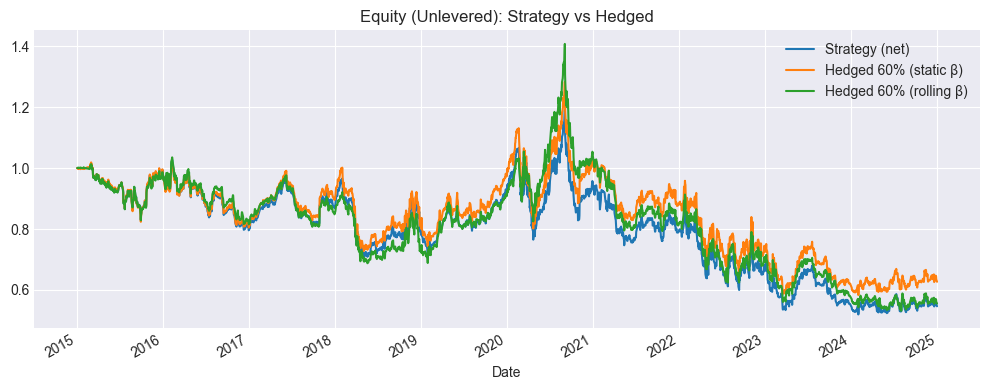

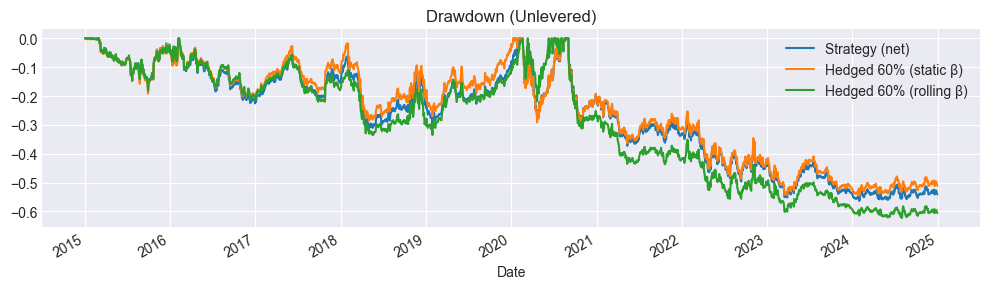

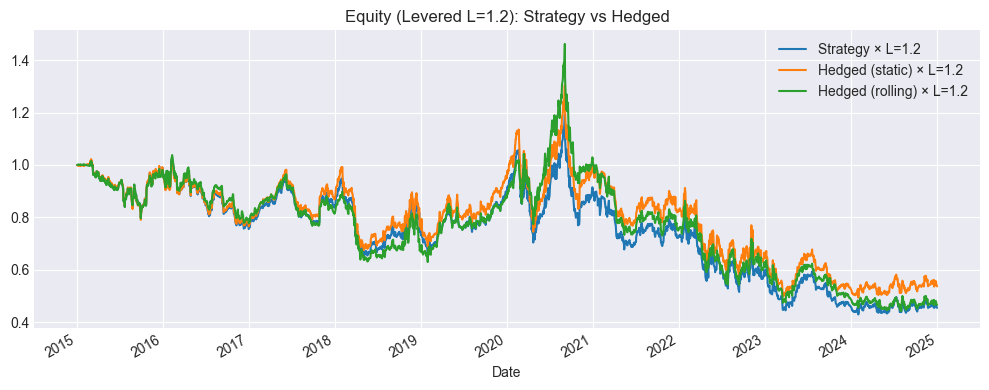

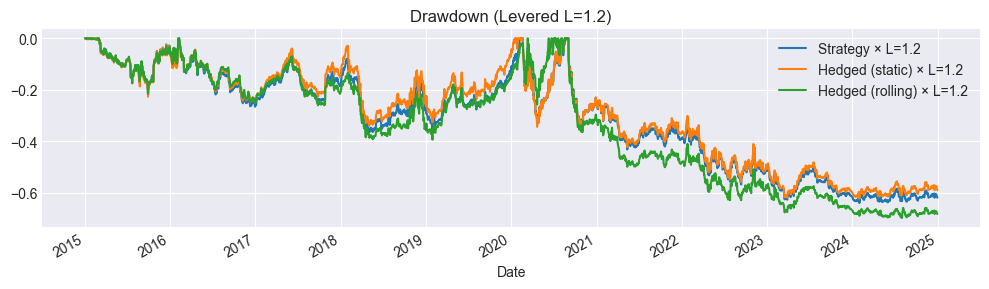

Static beta vs SPY: -0.183 | Hedge fraction: 60% | Rolling window: 126 days | Leverage: 1.2x


In [4]:
# -----------------------------
# CELL 4: Beta-Hedging (static & rolling) + Leverage, with safe metrics/plots
# -----------------------------
# Assumes from previous cells:
# - bt            : DataFrame with 'net' strategy returns (weekly-rebalanced, net of costs)
# - bench         : Benchmark OHLCV (SPY) aligned to strategy dates
# - BENCH         : Benchmark symbol string (e.g., "SPY")
# - TRADING_DAYS  : 252
# - CLOSE, feats, etc. already defined

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from IPython.display import display
except Exception:
    display = print

# 0) Parameters you can tweak
hedge_frac   = 0.60   # hedge 60% of estimated beta exposure
use_rolling  = True   # use rolling beta hedge in addition to static
rolling_win  = 126    # ~6 months of trading days
L            = 1.20   # leverage factor (e.g., 1.2x)

# 1) Strategy & benchmark daily returns  (force benchmark to 1-D Series)
r_strat = bt["net"].copy()

# Coerce bench Close to a 1-D Series, then compute returns and align to r_strat
bench_close_1d = pd.Series(bench["Close"].squeeze(), index=bench.index, name="Close")
r_bench = bench_close_1d.pct_change().reindex(r_strat.index).astype(float).fillna(0.0)

# 2) OLS beta estimators (robust to 1-D / 2-D inputs)
def estimate_beta(y: pd.Series, x: pd.Series) -> float:
    """
    OLS regression y = a + b*x; returns slope b (beta).
    Robust: coerces inputs to 1-D, aligns indexes.
    """
    y = pd.Series(y).astype(float)
    x = pd.Series(x).astype(float)
    # align by index
    xy = pd.concat([y, x], axis=1).dropna()
    if xy.empty:
        return float("nan")
    yy = xy.iloc[:, 0].to_numpy().reshape(-1)
    xx = xy.iloc[:, 1].to_numpy().reshape(-1)
    X = np.c_[np.ones_like(xx), xx]
    a, b = np.linalg.lstsq(X, yy, rcond=None)[0]
    return float(b)

def rolling_beta(y: pd.Series, x: pd.Series, window: int = 126) -> pd.Series:
    """
    Rolling OLS beta with seeding & fill; coerces to 1-D and aligns indexes.
    """
    y = pd.Series(y).astype(float)
    x = pd.Series(x).astype(float)
    xy = pd.concat([y, x], axis=1).dropna()
    betas = pd.Series(index=y.index, dtype=float)

    if len(xy) < window:
        # not enough data; fill with static beta
        b = estimate_beta(y, x)
        return pd.Series(b, index=y.index)

    # compute rolling on aligned data
    for i in range(window, len(xy)):
        yy = xy.iloc[i-window:i, 0].to_numpy().reshape(-1)
        xx = xy.iloc[i-window:i, 1].to_numpy().reshape(-1)
        X = np.c_[np.ones_like(xx), xx]
        a, b = np.linalg.lstsq(X, yy, rcond=None)[0]
        betas.loc[xy.index[i]] = float(b)

    # seed first window and fill across original index
    first_b = estimate_beta(xy.iloc[:window, 0], xy.iloc[:window, 1])
    betas.loc[xy.index[window-1]] = first_b
    betas = betas.reindex(y.index).bfill().ffill()
    return betas


# 3) Build hedged return series
beta_static = estimate_beta(r_strat, r_bench)
r_hedged_static = r_strat - hedge_frac * beta_static * r_bench

if use_rolling:
    beta_roll = rolling_beta(r_strat, r_bench, window=rolling_win)
    r_hedged_rolling = r_strat - hedge_frac * beta_roll * r_bench
else:
    r_hedged_rolling = None

# 4) Leverage: scale returns (note: in production you would add borrowing/financing costs)
r_strat_lever = r_strat * L
r_hedge_lever = r_hedged_static * L
r_rollh_lever = r_hedged_rolling * L if r_hedged_rolling is not None else None

# 5) Safe metrics (no crashes on empty series or zero vol)
def safe_metrics(returns: pd.Series, rf: float = 0.0) -> pd.Series:
    r = pd.Series(returns).dropna()
    n = len(r)
    if n == 0:
        return pd.Series({"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan,
                          "Sortino": np.nan, "MaxDD": np.nan})
    TR = (1 + r).prod()
    cagr = (TR ** (TRADING_DAYS / n) - 1) if TR > 0 else np.nan
    vol  = r.std(ddof=0) * np.sqrt(TRADING_DAYS)
    down = r[r < 0].std(ddof=0) * np.sqrt(TRADING_DAYS)
    ann_mean = r.mean() * TRADING_DAYS
    sharpe  = (ann_mean - rf) / vol  if vol  > 0 else np.nan
    sortino = (ann_mean - rf) / down if down > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq / eq.cummax() - 1).min() if len(eq) else np.nan
    return pd.Series({"CAGR": cagr, "Vol": vol, "Sharpe": sharpe,
                      "Sortino": sortino, "MaxDD": maxdd})

# 6) Comparison table
rows = {
    "Strategy (net)"                                  : safe_metrics(r_strat),
    f"Hedged {int(hedge_frac*100)}% (static β={beta_static:.2f})": safe_metrics(r_hedged_static),
}
if isinstance(r_hedged_rolling, pd.Series):
    rows[f"Hedged {int(hedge_frac*100)}% (rolling β, win={rolling_win})"] = safe_metrics(r_hedged_rolling)

rows[f"Strategy × L={L}"]            = safe_metrics(r_strat_lever)
rows[f"Hedged static × L={L}"]       = safe_metrics(r_hedge_lever)
if isinstance(r_rollh_lever, pd.Series):
    rows[f"Hedged rolling × L={L}"]  = safe_metrics(r_rollh_lever)

comp = pd.DataFrame(rows).round(4)
display(comp)

# 7) Safe equity helper
def safe_eq(r: pd.Series, name: str):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return None
    return (1 + r).cumprod().rename(name)

# 8) Unlevered equities & drawdowns
eq_list = [
    safe_eq(r_strat, "Strategy (net)"),
    safe_eq(r_hedged_static, f"Hedged {int(hedge_frac*100)}% (static β)"),
]
if isinstance(r_hedged_rolling, pd.Series):
    eq_list.append(safe_eq(r_hedged_rolling, f"Hedged {int(hedge_frac*100)}% (rolling β)"))

eqs = pd.concat([e for e in eq_list if e is not None], axis=1)

if not eqs.empty:
    ax = eqs.plot(figsize=(10,4))
    ax.set_title("Equity (Unlevered): Strategy vs Hedged")
    plt.tight_layout(); plt.show()

    dds = eqs.apply(lambda s: s / s.cummax() - 1)
    ax = dds.plot(figsize=(10,3))
    ax.set_title("Drawdown (Unlevered)")
    plt.tight_layout(); plt.show()
else:
    print("No unlevered equity to plot (series empty after dropna).")

# 9) Levered equities & drawdowns
eqL_list = [
    safe_eq(r_strat_lever, f"Strategy × L={L}"),
    safe_eq(r_hedge_lever, f"Hedged (static) × L={L}"),
]
if isinstance(r_rollh_lever, pd.Series):
    eqL_list.append(safe_eq(r_rollh_lever, f"Hedged (rolling) × L={L}"))

eqs_L = pd.concat([e for e in eqL_list if e is not None], axis=1)

if not eqs_L.empty:
    ax = eqs_L.plot(figsize=(10,4))
    ax.set_title(f"Equity (Levered L={L}): Strategy vs Hedged")
    plt.tight_layout(); plt.show()

    dds_L = eqs_L.apply(lambda s: s / s.cummax() - 1)
    ax = dds_L.plot(figsize=(10,3))
    ax.set_title(f"Drawdown (Levered L={L})")
    plt.tight_layout(); plt.show()
else:
    print("No levered equity to plot (series empty after dropna).")

# 10) Summary print
print(f"Static beta vs {BENCH}: {beta_static:.3f} | Hedge fraction: {hedge_frac:.0%} | Rolling window: {rolling_win} days | Leverage: {L:.1f}x")


# Phase 5 — Train/Test Split & Small Grid Search (WHY)

**Goal:** Pick parameters on a **training window** and evaluate on a **held-out test window** to reduce overfitting.

**We’ll vary:**
- Fast/slow SMA windows
- Momentum lookback
- Rebalance frequency

**We’ll pick:** the combo with best **train Sharpe (net)** and report **test metrics**.


,wf,ws,mom,freq,Sharpe_tr,CAGR_tr,MaxDD_tr
24,15,20,10,W-FRI,0.455732,0.081717,-0.305734
34,15,50,20,W-FRI,0.277213,0.037911,-0.314340
32,15,50,10,W-FRI,0.265224,0.035069,-0.339651
12,10,20,10,W-FRI,0.263885,0.034622,-0.356350
10,5,50,20,W-FRI,0.239678,0.028775,-0.376838
8,5,50,10,W-FRI,0.218466,0.024105,-0.364297
0,5,20,10,W-FRI,0.210217,0.022274,-0.365648
21,10,50,10,ME,0.203604,0.020533,-0.365503
26,15,20,20,W-FRI,0.178345,0.015280,-0.308201
33,15,50,10,ME,0.175730,0.013998,-0.392978


Best (train): fast=15, slow=20, mom=10, freq=W-FRI

Test metrics:


CAGR      -0.2106
Vol        0.2677
Sharpe    -0.7487
Sortino   -1.0934
MaxDD     -0.5527
dtype: float64

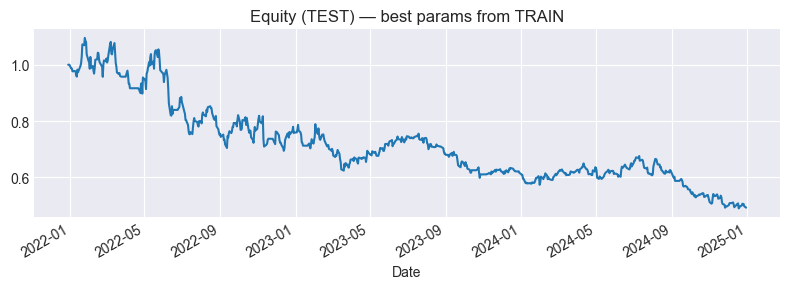

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# Reuse CLOSE, bench, backtest_weights from earlier cells

# 1) Helper: build signals directly from Close given hyperparams (no look-ahead)
def make_signals_from_close(close: pd.Series, w_fast=10, w_slow=30, mom_lb=20) -> pd.Series:
    sma_f = close.shift(1).rolling(w_fast).mean()
    sma_s = close.shift(1).rolling(w_slow).mean()
    mom   = close.shift(1) / close.shift(1+mom_lb) - 1
    sig = pd.Series(0.0, index=close.index)
    long  = (sma_f > sma_s) & (mom > 0)
    short = (sma_f < sma_s) & (mom < 0)
    sig[long]  =  1.0
    sig[short] = -1.0
    return sig

def stack_weights_from_signals(signals_dict: dict[str, pd.Series]) -> pd.DataFrame:
    idx = next(iter(signals_dict.values())).index
    W = pd.DataFrame(index=idx, columns=list(signals_dict.keys()), dtype=float)
    for t in idx:
        row = pd.Series({k: v.loc[t] for k, v in signals_dict.items()}, dtype=float)
        gross = row.abs().sum()
        W.loc[t] = (row / gross) if gross > 0 else 0.0
    return W.fillna(0.0)

def safe_metrics(returns: pd.Series, rf: float = 0.0) -> pd.Series:
    r = pd.Series(returns).dropna()
    n = len(r)
    if n == 0:
        return pd.Series({"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan,
                          "Sortino": np.nan, "MaxDD": np.nan})
    TR = (1 + r).prod()
    cagr = (TR ** (TRADING_DAYS / n) - 1) if TR > 0 else np.nan
    vol  = r.std(ddof=0) * np.sqrt(TRADING_DAYS)
    down = r[r < 0].std(ddof=0) * np.sqrt(TRADING_DAYS)
    ann  = r.mean() * TRADING_DAYS
    sharpe  = (ann) / vol  if vol  > 0 else np.nan
    sortino = (ann) / down if down > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq/eq.cummax() - 1).min() if len(eq) else np.nan
    return pd.Series({"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "Sortino": sortino, "MaxDD": maxdd})

# 2) Train/test split (70/30)
idx = CLOSE.index
split = int(len(idx) * 0.7)
idx_tr, idx_te = idx[:split], idx[split:]

# 3) Small grid
fast_list = [5, 10, 15]
slow_list = [20, 30, 50]
mom_list  = [10, 20]
freq_list = ["W-FRI", "ME"]   # was ["W-FRI", "M"]


tcost = 0.0005

rows = []
for wf in fast_list:
    for ws in slow_list:
        if wf >= ws:
            continue  # enforce fast < slow
        for mlb in mom_list:
            # signals for each asset
            sigs = {sym: make_signals_from_close(CLOSE[sym], wf, ws, mlb) for sym in CLOSE.columns}
            W = stack_weights_from_signals(sigs)

            for freq in freq_list:
                bt_tr = backtest_weights(CLOSE.loc[idx_tr], W.loc[idx_tr], rebalance=freq, tcost=tcost)
                mtr   = safe_metrics(bt_tr["net"])
                rows.append({
                    "wf": wf, "ws": ws, "mom": mlb, "freq": freq,
                    "Sharpe_tr": mtr["Sharpe"], "CAGR_tr": mtr["CAGR"], "MaxDD_tr": mtr["MaxDD"]
                })

grid = pd.DataFrame(rows).dropna().sort_values("Sharpe_tr", ascending=False)
display(grid.head(10))

# 4) Evaluate best on TEST
if not grid.empty:
    best = grid.iloc[0]
    wf, ws, mlb, freq = int(best.wf), int(best.ws), int(best.mom), best.freq
    print(f"Best (train): fast={wf}, slow={ws}, mom={mlb}, freq={freq}")

    sigs = {sym: make_signals_from_close(CLOSE[sym], wf, ws, mlb) for sym in CLOSE.columns}
    W = stack_weights_from_signals(sigs)
    bt_te = backtest_weights(CLOSE.loc[idx_te], W.loc[idx_te], rebalance=freq, tcost=tcost)
    print("\nTest metrics:")
    display(safe_metrics(bt_te["net"]).round(4))

    # Quick equity plot (test only)
    eq_te = (1 + bt_te["net"]).cumprod()
    ax = eq_te.plot(figsize=(8,3), title="Equity (TEST) — best params from TRAIN")
    plt.tight_layout(); plt.show()
else:
    print("No valid configurations produced non-empty returns on TRAIN.")


# Phase 7 — Save Artifacts (WHY)

**Goal:** Make your results reproducible and shareable.

**We’ll:**
- Create `figures/` and `reports/` if missing.
- Save key plots (equity, drawdown, Monte Carlo).
- Save tables (metrics, grid search results) as CSV.
- Save best parameters as JSON for future runs.


In [7]:
# -----------------------------
# CELL 7: Save figures and tables
# -----------------------------
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure folders exist
os.makedirs("figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# 1) Save latest comparison table from Cell 4 if it exists
if "comp" in globals():
    comp.to_csv("reports/metrics_hedge_leverage.csv", index=True)
    print("Saved: reports/metrics_hedge_leverage.csv")

# 2) Save the grid search (Cell 5) if it exists
if "grid" in globals():
    grid.to_csv("reports/grid_search_train.csv", index=False)
    print("Saved: reports/grid_search_train.csv")

# 3) Save cost sensitivity (Cell 6) if it exists
if "sens" in globals():
    sens.to_csv("reports/cost_sensitivity.csv", index=False)
    print("Saved: reports/cost_sensitivity.csv")

# 4) Save key plots (re-generate quickly if needed)
def plot_and_save_equity(series_dict, title, path):
    plt.figure(figsize=(10,4))
    pd.concat(series_dict, axis=1).dropna().plot(ax=plt.gca())
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()
    print("Saved:", path)

# Equity (strategy vs benchmark) from Cell 2
try:
    eq_port  = (1 + bt["net"]).cumprod().rename("Strategy (net)")
    eq_bench = (1 + bench["Close"].pct_change().reindex(bt.index).fillna(0.0)).cumprod().rename(BENCH)
    plot_and_save_equity({"Strategy (net)": eq_port, BENCH: eq_bench},
                         "Equity — Strategy vs Benchmark",
                         "figures/equity_strategy_vs_bench.png")
except Exception as e:
    print("Skip equity plot save (Cell 2 not in scope):", e)

# Monte Carlo + optimal point (Cell 3) — save only if variables exist
if all(k in globals() for k in ["vols_mc","rets_mc","srs_mc","v_opt","r_opt"]):
    fig, ax = plt.subplots(figsize=(8,5))
    sc = ax.scatter(vols_mc, rets_mc, c=srs_mc)
    ax.scatter([v_opt],[r_opt], s=140, edgecolors="black", zorder=5)
    ax.set_xlabel("Annualized Volatility"); ax.set_ylabel("Annualized Return")
    ax.set_title("Monte Carlo & Max-Sharpe"); plt.colorbar(sc, label="Sharpe")
    plt.tight_layout(); fig.savefig("figures/montecarlo_maxsharpe.png", dpi=150)
    plt.close(fig); print("Saved: figures/montecarlo_maxsharpe.png")

# 5) Save “best params” (from grid search) if present
best_params = {}
if "grid" in globals() and not grid.empty:
    b = grid.iloc[0]
    best_params = {"fast": int(b.wf), "slow": int(b.ws), "mom": int(b.mom), "freq": str(b.freq)}
    with open("reports/best_params.json","w") as f:
        json.dump(best_params, f, indent=2)
    print("Saved: reports/best_params.json")
else:
    print("No grid/best params to save (skip).")


Saved: reports/metrics_hedge_leverage.csv
Saved: reports/grid_search_train.csv
Skip equity plot save (Cell 2 not in scope): 'str' object is not callable
Saved: figures/montecarlo_maxsharpe.png
Saved: reports/best_params.json


# Phase 8 — Volatility Targeting (WHY)

**Goal:** Normalize risk over time. If the strategy’s volatility drifts, scale the exposure to hit a **target annualized vol** (e.g., 10%).

**Why:** More stable risk → smoother equity → often higher risk-adjusted returns when combined with sensible caps.

**We’ll:**
- Compute **rolling realized vol** (e.g., 20 trading days).
- Compute a **scaling factor** = (target_vol / realized_vol).
- Apply caps (e.g., max leverage 2.0x) to avoid runaway scaling in quiet periods.
- Compare metrics and plots vs the unscaled strategy.


,Strategy (net),Vol-targeted (10%)
CAGR,-0.0588,0.0039
Vol,0.2304,0.1255
Sharpe,-0.1474,0.0931
Sortino,-0.1920,0.1349
MaxDD,-0.5633,-0.2645


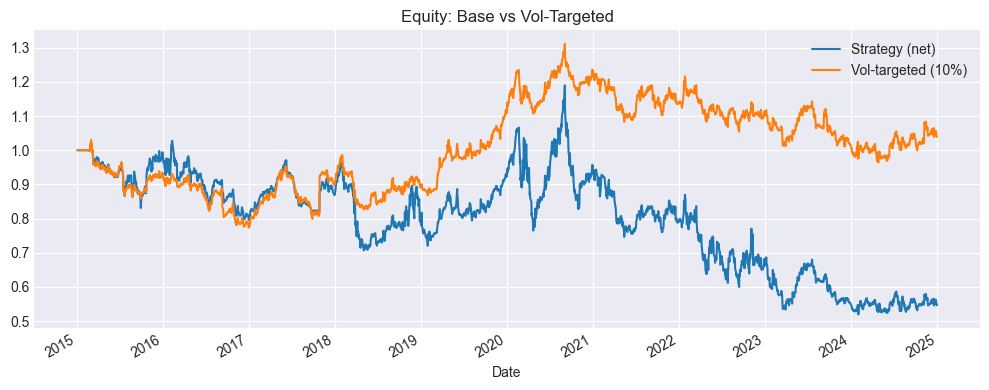

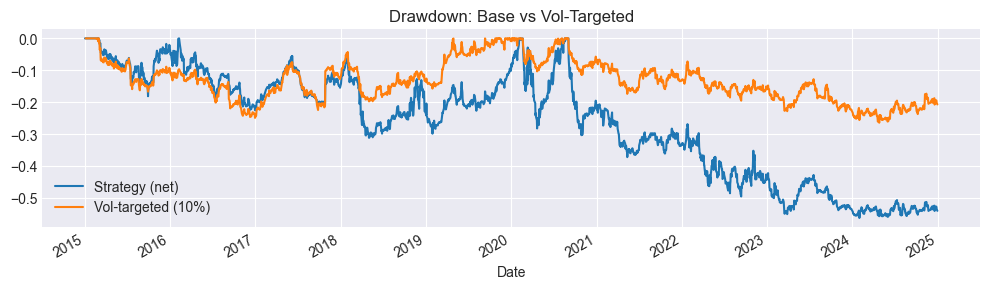

Target vol: 10% | Window: 20d | Caps: [0.25x, 2.0x]


In [8]:
# -----------------------------
# CELL 8: Volatility targeting on strategy returns
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
TARGET_VOL = 0.10    # 10% annualized target
ROLL_WIN   = 20      # 20 trading days ~ 1 month
MAX_LEV    = 2.0     # cap leverage when vol is very low
MIN_LEV    = 0.25    # optional floor to avoid over-deleveraging

# 1) Base returns (net) from Cell 2
r = bt["net"].copy().dropna()

# 2) Rolling realized vol (annualized) using population std
roll_vol = r.rolling(ROLL_WIN).std(ddof=0) * np.sqrt(TRADING_DAYS)

# 3) Scaling factor to hit target vol, with caps
scale = TARGET_VOL / roll_vol
scale = scale.clip(lower=MIN_LEV, upper=MAX_LEV).fillna(1.0)

# 4) Apply scaling to daily returns (shift(1) to avoid contemporaneous look-ahead)
r_target = (r * scale.shift(1)).dropna()

# 5) Metrics helper
def safe_metrics(returns: pd.Series, rf: float = 0.0) -> pd.Series:
    r = pd.Series(returns).dropna()
    n = len(r)
    if n == 0:
        return pd.Series({"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan,
                          "Sortino": np.nan, "MaxDD": np.nan})
    TR = (1 + r).prod()
    cagr = (TR ** (TRADING_DAYS / n) - 1) if TR > 0 else np.nan
    vol  = r.std(ddof=0) * np.sqrt(TRADING_DAYS)
    down = r[r < 0].std(ddof=0) * np.sqrt(TRADING_DAYS)
    ann  = r.mean() * TRADING_DAYS
    sharpe  = ann / vol  if vol  > 0 else np.nan
    sortino = ann / down if down > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq/eq.cummax() - 1).min() if len(eq) else np.nan
    return pd.Series({"CAGR": cagr, "Vol": vol, "Sharpe": sharpe,
                      "Sortino": sortino, "MaxDD": maxdd})

# 6) Compare metrics
m_base   = safe_metrics(r).round(4)
m_target = safe_metrics(r_target).round(4)
display(pd.concat([m_base.rename("Strategy (net)"),
                   m_target.rename(f"Vol-targeted ({int(TARGET_VOL*100)}%)")], axis=1))

# 7) Equity & drawdown comparison
eq_base   = (1 + r).cumprod().rename("Strategy (net)")
eq_target = (1 + r_target).cumprod().rename(f"Vol-targeted ({int(TARGET_VOL*100)}%)")

ax = pd.concat([eq_base, eq_target], axis=1).plot(figsize=(10,4))
ax.set_title("Equity: Base vs Vol-Targeted")
plt.tight_layout(); plt.show()

def drawdown(eq): return eq/eq.cummax() - 1
ax = pd.concat([drawdown(eq_base), drawdown(eq_target)], axis=1).plot(figsize=(10,3))
ax.set_title("Drawdown: Base vs Vol-Targeted")
plt.tight_layout(); plt.show()

print(f"Target vol: {TARGET_VOL:.0%} | Window: {ROLL_WIN}d | Caps: [{MIN_LEV}x, {MAX_LEV}x]")


In [9]:
# -----------------------------
# CELL 9: Write summary report to reports/summary.md
# -----------------------------
import os, json, datetime as dt
import pandas as pd

os.makedirs("reports", exist_ok=True)

# Collect what we have (guard if not defined)
summary = {
    "generated_at": dt.datetime.now().isoformat(timespec="seconds"),
    "universe": list(CLOSE.columns) if "CLOSE" in globals() else [],
    "date_range": [str(CLOSE.index.min().date()), str(CLOSE.index.max().date())] if "CLOSE" in globals() else [],
    "benchmark": BENCH if "BENCH" in globals() else "SPY",
}

# Strategy baseline metrics (Cell 2)
def try_metrics(name, s):
    try:
        from math import isnan
        from pandas import Series
        if s is None: return {}
        out = s.to_dict() if hasattr(s, "to_dict") else {}
        return {k: (None if (isinstance(v, float) and (pd.isna(v))) else float(v)) for k, v in out.items()}
    except Exception:
        return {}

if "bt" in globals():
    from math import isnan
    TRADING_DAYS = 252
    def safe_metrics(returns: pd.Series, rf: float = 0.0) -> pd.Series:
        r = pd.Series(returns).dropna()
        n = len(r)
        if n == 0:
            return pd.Series({"CAGR": None, "Vol": None, "Sharpe": None, "Sortino": None, "MaxDD": None})
        TR = (1 + r).prod()
        cagr = (TR ** (TRADING_DAYS / n) - 1) if TR > 0 else None
        vol  = r.std(ddof=0) * (TRADING_DAYS**0.5)
        down = r[r < 0].std(ddof=0) * (TRADING_DAYS**0.5)
        ann  = r.mean() * TRADING_DAYS
        sharpe  = (ann / vol)  if vol  and vol  > 0 else None
        sortino = (ann / down) if down and down > 0 else None
        eq = (1 + r).cumprod()
        maxdd = (eq/eq.cummax() - 1).min() if len(eq) else None
        return pd.Series({"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "Sortino": sortino, "MaxDD": maxdd})
    summary["metrics_strategy_net"] = try_metrics("strategy", safe_metrics(bt["net"]))
else:
    summary["metrics_strategy_net"] = {}

# Comparison table from Cell 4 (hedge/leverage)
if "comp" in globals():
    summary["hedge_leverage_table_path"] = "reports/metrics_hedge_leverage.csv"

# Grid search (Cell 5)
best_params = {}
if "grid" in globals() and not grid.empty:
    b = grid.iloc[0]
    best_params = {"fast": int(b.wf), "slow": int(b.ws), "mom": int(b.mom), "freq": str(b.freq)}
    summary["best_params"] = best_params
    summary["grid_path"] = "reports/grid_search_train.csv"

# Cost sensitivity (Cell 6)
if "sens" in globals():
    summary["cost_sensitivity_path"] = "reports/cost_sensitivity.csv"

# Vol targeting (Cell 8)
if "r_target" in globals():
    summary["vol_targeting"] = {
        "target_vol_ann": 0.10,
        "window_days": 20,
        "caps": [0.25, 2.0]
    }

# Write Markdown
lines = []
lines.append("# Quant Project — Summary\n")
lines.append(f"- Generated at: **{summary['generated_at']}**")
if summary["universe"]:
    lines.append(f"- Universe: **{', '.join(summary['universe'])}**")
if summary["date_range"]:
    lines.append(f"- Date range: **{summary['date_range'][0]} → {summary['date_range'][1]}**")
lines.append(f"- Benchmark: **{summary['benchmark']}**\n")

lines.append("## Baseline Strategy (net) — Metrics")
m = summary["metrics_strategy_net"]
if m:
    lines += [f"- **{k}**: {v:.4f}" if isinstance(v, float) else f"- **{k}**: {v}" for k,v in m.items()]
else:
    lines.append("_Metrics unavailable in this session._")

if "best_params" in summary:
    lines.append("\n## Best Params from Train (Grid Search)")
    bp = summary["best_params"]
    lines.append(f"- fast={bp['fast']}, slow={bp['slow']}, mom={bp['mom']}, freq={bp['freq']}")
    lines.append(f"- Grid table: `reports/grid_search_train.csv`")

if "hedge_leverage_table_path" in summary:
    lines.append("\n## Hedge & Leverage Comparison")
    lines.append(f"- See: `{summary['hedge_leverage_table_path']}`")

if "cost_sensitivity_path" in summary:
    lines.append("\n## Transaction Cost Sensitivity")
    lines.append(f"- See: `{summary['cost_sensitivity_path']}`")

if "vol_targeting" in summary:
    vt = summary["vol_targeting"]
    lines.append("\n## Volatility Targeting")
    lines.append(f"- Target annual vol: **{vt['target_vol_ann']:.0%}**  | Window: **{vt['window_days']}d**  | Caps: **[{vt['caps'][0]}×, {vt['caps'][1]}×]**")

md_path = "reports/summary.md"
with open(md_path, "w") as f:
    f.write("\n".join(lines))

print(f"Wrote: {md_path}")


Wrote: reports/summary.md
